## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn 

%matplotlib inline
plt.style.use('ggplot')

from image_clean import *
from sklearn.model_selection import train_test_split

# Neural Network Imports
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Import Image Dataset

In [2]:
training_df, validation_df, test_df, df = clean_image_df()

In [4]:
df.shape

(35887, 4)

In [7]:
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [9]:
def fer2013_show_instance(index):
    """Shows the image and the emotion label of the index's instance."""
    image = np.reshape(training_df.at[index, "pixels"].split(" "), (48, 48)).astype("float")
    image -= np.mean(image)
    image /= np.std(image)
    print(Emotions[training_df.at[index, "emotion"]])
    plt.imshow(image, cmap="gray")

Sad


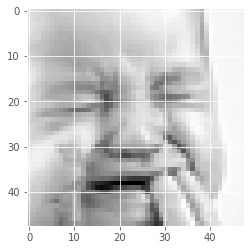

In [10]:
fer2013_show_instance(np.random.randint(0,len(training_df)))

In [11]:
def fer2013_to_X(df):
    """Transforms the (blank separated) pixel strings in the DataFrame to an 3-dimensional array 
    (1st dim: instances, 2nd and 3rd dims represent 2D image)."""
    
    X = []
    pixels_list = df["pixels"].values
    
    for pixels in pixels_list:
        single_image = np.reshape(pixels.split(" "), (48, 48)).astype("float")
        X.append(single_image)
        
    # Convert list to 4D array:
    X = np.expand_dims(np.array(X), -1)
    
    # Normalize image data:
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    
    return X

In [12]:
X_val = fer2013_to_X(validation_df)

In [13]:
# Get labels (one-hot encoded)
y_val = pd.get_dummies(validation_df['emotion']).values
y_val.shape

(3589, 7)

In [14]:
X = fer2013_to_X(training_df)

In [15]:
# Get labels (one-hot encoded)
y = pd.get_dummies(training_df['emotion']).values
y.shape

(28709, 7)

In [16]:

model = Sequential()
input_shape = (48,48,1)
model.add(Conv2D(64, (3, 3), input_shape=input_shape,activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=Adam(lr=0.001))













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [19]:
earlystop = EarlyStopping(monitor='val_loss',
                          patience=20,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=20,
                              verbose=1,
                              min_delta=0.0001)

In [20]:
h=model.fit(x=X,     
            y=y, 
            batch_size=64, 
            epochs=100, 
            verbose=1, 
            validation_data=(X_val,y_val),
            shuffle=True,
            callbacks=[earlystop, reduce_lr]
            )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 32s 1ms/step - loss: 1.7706 - acc: 0.3180 - val_loss: 1.4990 - val_acc: 0.4210
Epoch 2/100
28709/28709 [==============================] - 29s 1ms/step - loss: 1.3838 - acc: 0.4660 - val_loss: 1.2755 - val_acc: 0.5127
Epoch 3/100
28709/28709 [==============================] - 29s 1ms/step - loss: 1.2159 - acc: 0.5338 - val_loss: 1.2361 - val_acc: 0.5364
Epoch 4/100
28709/28709 [==============================] - 29s 1ms/step - loss: 1.1081 - acc: 0.5823 - val_loss: 1.1684 - val_acc: 0.5536
Epoch 5/100
28709/28709 [==============================] - 29s 1ms/step - loss: 1.0218 - acc: 0.6184 - val_loss: 1.1387 - val_acc: 0.5737
Epoch 6/100
28709/28709 [==============================] - 29s 1ms/step - loss: 0.9360 - acc: 0.6483 - val_loss: 1.1767 - val_acc: 0.5726
Epoch 7/100
28709/28709 [==

In [21]:
scores = model.evaluate(X_val, y_val)
print('%s: %.2f%%'% (model.metrics_names[1], scores[1]*100))

3589/3589 [==============================] - 2s 472us/step
acc: 59.46%


In [27]:
model.save('fer2013.h5')
model.save_weights('fer2013_weights.h5')

In [22]:
def get_emotion(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

In [5]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_val, preds)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

NameError: name 'y_val' is not defined

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)       512       
__________

In [6]:
preds = model.predict(X_val, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

NameError: name 'model' is not defined

In [32]:
def create_plot(model_history):
        '''Check the logloss of both train and validation, make sure they are close and have plateau'''
        plt.figure(figsize = (14, 7))
        plt.plot(model_history.history['acc'])
        plt.plot(model_history.history['val_acc'])
        plt.title('Model Loss', fontsize = 20)
        plt.ylabel('Loss', fontsize = 15)
        plt.xlabel('Epoch', fontsize = 15)
        plt.legend(['Training Loss', 'Testing Loss'], loc='upper left', fontsize = 13)
        plt.show()

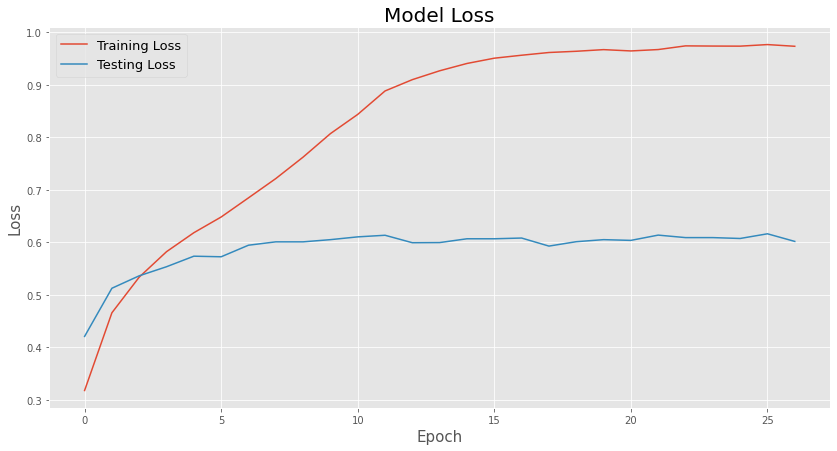

In [33]:
create_plot(h)

[0]


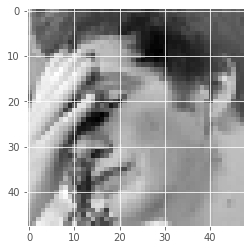

> testing image index: 2996
> true emotion: sad
> predicted emotion: angry


In [27]:
img_indx = np.uint32(np.random.rand()*(validation_df.shape[0] - 1))
sample = X_val[img_indx, :]
sample = sample.reshape(48, 48)

pred_cls = model.predict_classes(sample.reshape(1, 48, 48, 1))
print(pred_cls)
plt.imshow(sample, cmap='gray')
plt.show()
print('> testing image index: %d\n> true emotion: %s\n> predicted emotion: %s' % (img_indx, get_emotion(y_val[img_indx, :]), get_emotion(pred_cls)))

In [6]:
import cv2

In [11]:
im4 = '../../data/live_images/angry_test_male.jpeg'
face1 = agender.detect_genders_ages(cv2.imread(im4))

In [12]:
face1[0]['gender']

0.13904682

In [22]:
# from __future__ import division
# from keras.models import load_model
# from pyagender import PyAgender
# import os
# import cv2
# import numpy as np
# import numpy as np
# from IPython.display import clear_output, Image, display
# from io import BytesIO
# import PIL.Image

# print('Loading Model...')
# model = load_model('../../data/fer2013.h5')
# model.load_weights('../../data/fer2013_weights.h5')
# print('Model Loaded.')

# # Image Resize
# WIDTH = 48
# HEIGHT = 48

# labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]


# def emotion_detect(path):
#     agender = PyAgender()
#     #loading image
#     full_size_image = cv2.imread(path)
#     print("Image Loaded")
#     gray=cv2.cvtColor(full_size_image,cv2.COLOR_RGB2GRAY)
#     face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#     faces = face.detectMultiScale(gray, 1.3, 10)

#     # detecting faces
#     for (x, y, w, h) in faces:
#         roi_gray = gray[y:y + h, x:x + w]
#         cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
#         cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
#         cv2.rectangle(full_size_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
#         #predicting the emotion
#         yhat= model.predict(cropped_img)
#         cv2.putText(full_size_image, labels[int(np.argmax(yhat))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
#         print("Emotion: "+labels[int(np.argmax(yhat))])


# #     cv2.imshow('Emotion',full_size_image)
#     a = np.uint8(np.clip(full_size_image, 0, 255))
#     f = BytesIO()
#     PIL.Image.fromarray(a).save(f, 'jpeg')
#     display(Image(data=f.getvalue()))
#     face1 = agender.detect_genders_ages(cv2.imread(path))
#     gender = face1[0]['gender']
#     if gender >= 0.5:
#         print('Female')
#     else:
#         print('Male')
    
    

#     cv2.waitKey(0)

In [1]:
import cv2

In [3]:
full_size_image = cv2.imread('../../data/live_images/female_happy.jpg')

In [5]:
full_size_image.shape

(874, 960, 3)

Image Loaded
Emotion: Angry


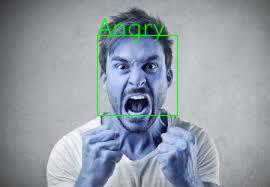

Male


In [21]:
emotion_detect('../../data/live_images/angry_test_male.jpeg')